In [1]:
import sys
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('./../src/')
from manuscript import sankey_side_by_side as sankey
from manuscript import clustering, datasets, inout, export

pd.options.display.max_columns = 200
mpl.rcParams["figure.figsize"] = (10, 8)
mpl.rcParams["pdf.fonttype"] = 42
mpl.rcParams["font.family"] = "Arial"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

import IPython.display
IPython.display.display(IPython.display.HTML("<style>.container { width:90% !important; }</style>"))

fonts = inout.get_resource_path('fonts')
for f in os.listdir(fonts):
    if f.endswith(".ttf"):
        mpl.font_manager.fontManager.addfont(f"{fonts}/{f}")
        
def dump_figure(name):
    export.image(
        user,
        f'{outfolder}/{name}',
    )
def dump_table(df, name):
    export.full_frame(
        user, 
        f'{outfolder}/{name}', 
        df, 
        index=True,
        date=True
    )

In [2]:
user = 'CAG'     # defines top hierarchy of output folder
outfolder = 'm2_clustering'    # name of notebook

In [3]:
p = os.path.join(
    inout.get_path_from_settings('resources_path'),
    'mimic/mimic_data7-19-22.csv'
)

In [4]:
data = pd.read_csv(p, encoding="unicode_escape", index_col=0)

In [5]:
data.shape

(15677, 40)

In [6]:
data = data.rename(columns={
    'ecmo_yn': 'ECMO_flag',
    'vent_yn': 'Intubation_flag',
    'dialysis_yn': 'Dialysis_flag',
    'max_temp': 'Temperature', 
    'max_hr': 'Heart_rate',
    'min_map': 'Mean_arterial_pressure', 
    'max_norepi': 'Norepinephrine_rate', 
    'levo_flag': 'Norepinephrine_flag', 
    'max_rr': 'Respiratory_rate',
    'min_spo2': 'Oxygen_saturation', 
    'min_uop': 'Urine_output', 
    'min_eye': 'GCS_eye_opening',
    'min_motor': 'GCS_motor_response', 
    'min_verbal': 'GCS_verbal_response', 
    'median_rass': 'RASS_score', 
    'avg_peep': 'PEEP',
    'avg_tv': 'Tidal_volume', 
    'avg_platpress': 'Plateau_pressure',
    'avg_rr': 'Vent_respiratory_rate', 
    'avg_fio2': 'FiO2', 
    'avg_ph': 'ABG_pH', 
    'avg_pco2': 'ABG_PaCO2',
    'pf_ratio': 'PaO2FIO2_ratio', 
    'min_plt': 'Platelets',  
    'max_cr': 'Creatinine',
    'max_bili': 'Bilirubin',
    'max_sofa':'SOFA_score', 
    'stay_id': 'Patient_id',
    'day_number': 'day',
    'hospital_expire_flag':'Binary_outcome',

})

In [7]:
data.columns

Index(['Patient_id', 'intime', 'outtime', 'los', 'day', 'day',
       'Intubation_flag', 'Norepinephrine_rate', 'Mean_arterial_pressure',
       'min_gcs', 'Urine_output', 'Bilirubin', 'Creatinine', 'Platelets',
       'SOFA_score', 'Dialysis_flag', 'FiO2', 'PEEP', 'Vent_respiratory_rate',
       'Tidal_volume', 'avg_mv', 'Plateau_pressure', 'min_hr', 'Heart_rate',
       'min_rr', 'Respiratory_rate', 'min_temp', 'Temperature',
       'Oxygen_saturation', 'ABG_pH', 'ABG_PaCO2', 'ECMO_flag', 'RASS_score',
       'GCS_verbal_response', 'GCS_motor_response', 'GCS_eye_opening',
       'PaO2FIO2_ratio', 'discharge_location', 'Binary_outcome',
       'Norepinephrine_flag'],
      dtype='object')

In [8]:
data_columns= [
'Intubation_flag',
       'Norepinephrine_rate', 'Mean_arterial_pressure', 'min_gcs',
       'Urine_output', 'Bilirubin', 'Creatinine', 'Platelets', 'SOFA_score',
       'Dialysis_flag', 'FiO2', 'PEEP', 'Vent_respiratory_rate', 'Tidal_volume',
       'Plateau_pressure', 'Heart_rate', 
       'Respiratory_rate', 'Temperature', 'Oxygen_saturation',
       'ABG_pH', 'ABG_PaCO2', 'RASS_score', 'GCS_verbal_response',
       'GCS_motor_response', 'GCS_eye_opening', 'PaO2FIO2_ratio','Norepinephrine_flag'
]

In [55]:
len(data_columns)

27

In [56]:
data.Patient_id.nunique()

1284

In [9]:
data_mtx = data[data_columns].copy()
data_mtx = data_mtx.rank(axis=0, pct=True)

In [10]:
data_dist_col = clustering.get_distances(data_mtx.transpose(), approach='nan_euclidean')   
col_tree = clustering.get_tree(data_dist_col, approach='ward')

In [11]:
cutoff_groups = clustering.identify_related_features(data[data_columns])

In [12]:
threshold_for_relatedness = 0.7
# data_mtx = clustering.reweight_related_features(
#     data_mtx, 
#     approach='square_root', 
#     groups=cutoff_groups[threshold_for_relatedness])

data_mtx_for_similarity = data_mtx.copy()
data_mtx_for_similarity = clustering.reweight_related_features(
    data_mtx_for_similarity, 
    approach='mean_rank', 
    groups=cutoff_groups[threshold_for_relatedness])

In [13]:
%%time

#1. Similarity approach
corr_mtx = data_mtx_for_similarity.transpose().corr("pearson")
data_dist = clustering.get_distances(corr_mtx, approach='euclidean')   
tree = clustering.get_tree(df_dist=data_dist, approach='ward')
out, assignments = clustering.table_with_assignments(
    tree=tree,
    labels=data.index
)
sign_mortality_similarity = clustering.get_sign_mortalities(
    df_assigned_clusters=out,
    df_with_mortality=data
)
sign_mortality_similarity.loc[:, 'approach'] = 'similarity'



CPU times: user 5min 53s, sys: 8.43 s, total: 6min 1s
Wall time: 4min 15s


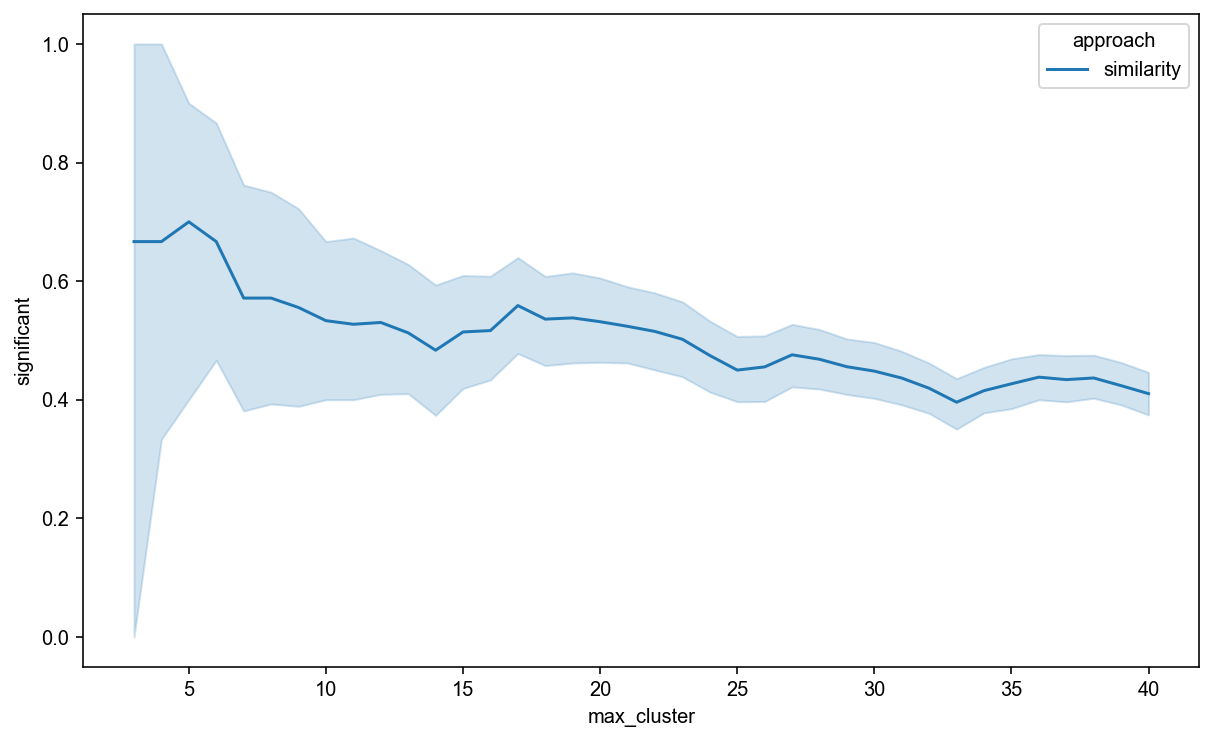

In [16]:
mpl.rcParams["figure.figsize"] = (10, 6)
sns.lineplot(
    x='max_cluster',
    y='significant',
    data=sign_mortality_similarity.reset_index(),
    hue='approach'
)
dump_figure('approaches_significance.pdf')

In [17]:
#store in dictionary
approaches = {
    'Similarity' : {
        'feature_matrix':data_mtx,
        'data_dist':data_dist,
        'tree':tree,
        'assignments_table':out,
        'assignments':assignments
    },
    # 'Ranked-Euclidean' : {
    #     'feature_matrix':data_mtx,
    #     'data_dist':rank_data_dist,
    #     'tree':rank_tree,
    #     'assignments_table':rank_out,
    #     'assignments':rank_assignments
    # },
    # 'Normalized-Euclidean' : {
    #     'feature_matrix':data_mtx,
    #     'data_dist':norm_data_dist,
    #     'tree':norm_tree,
    #     'assignments_table':norm_out,
    #     'assignments':norm_assignments
    # }
}

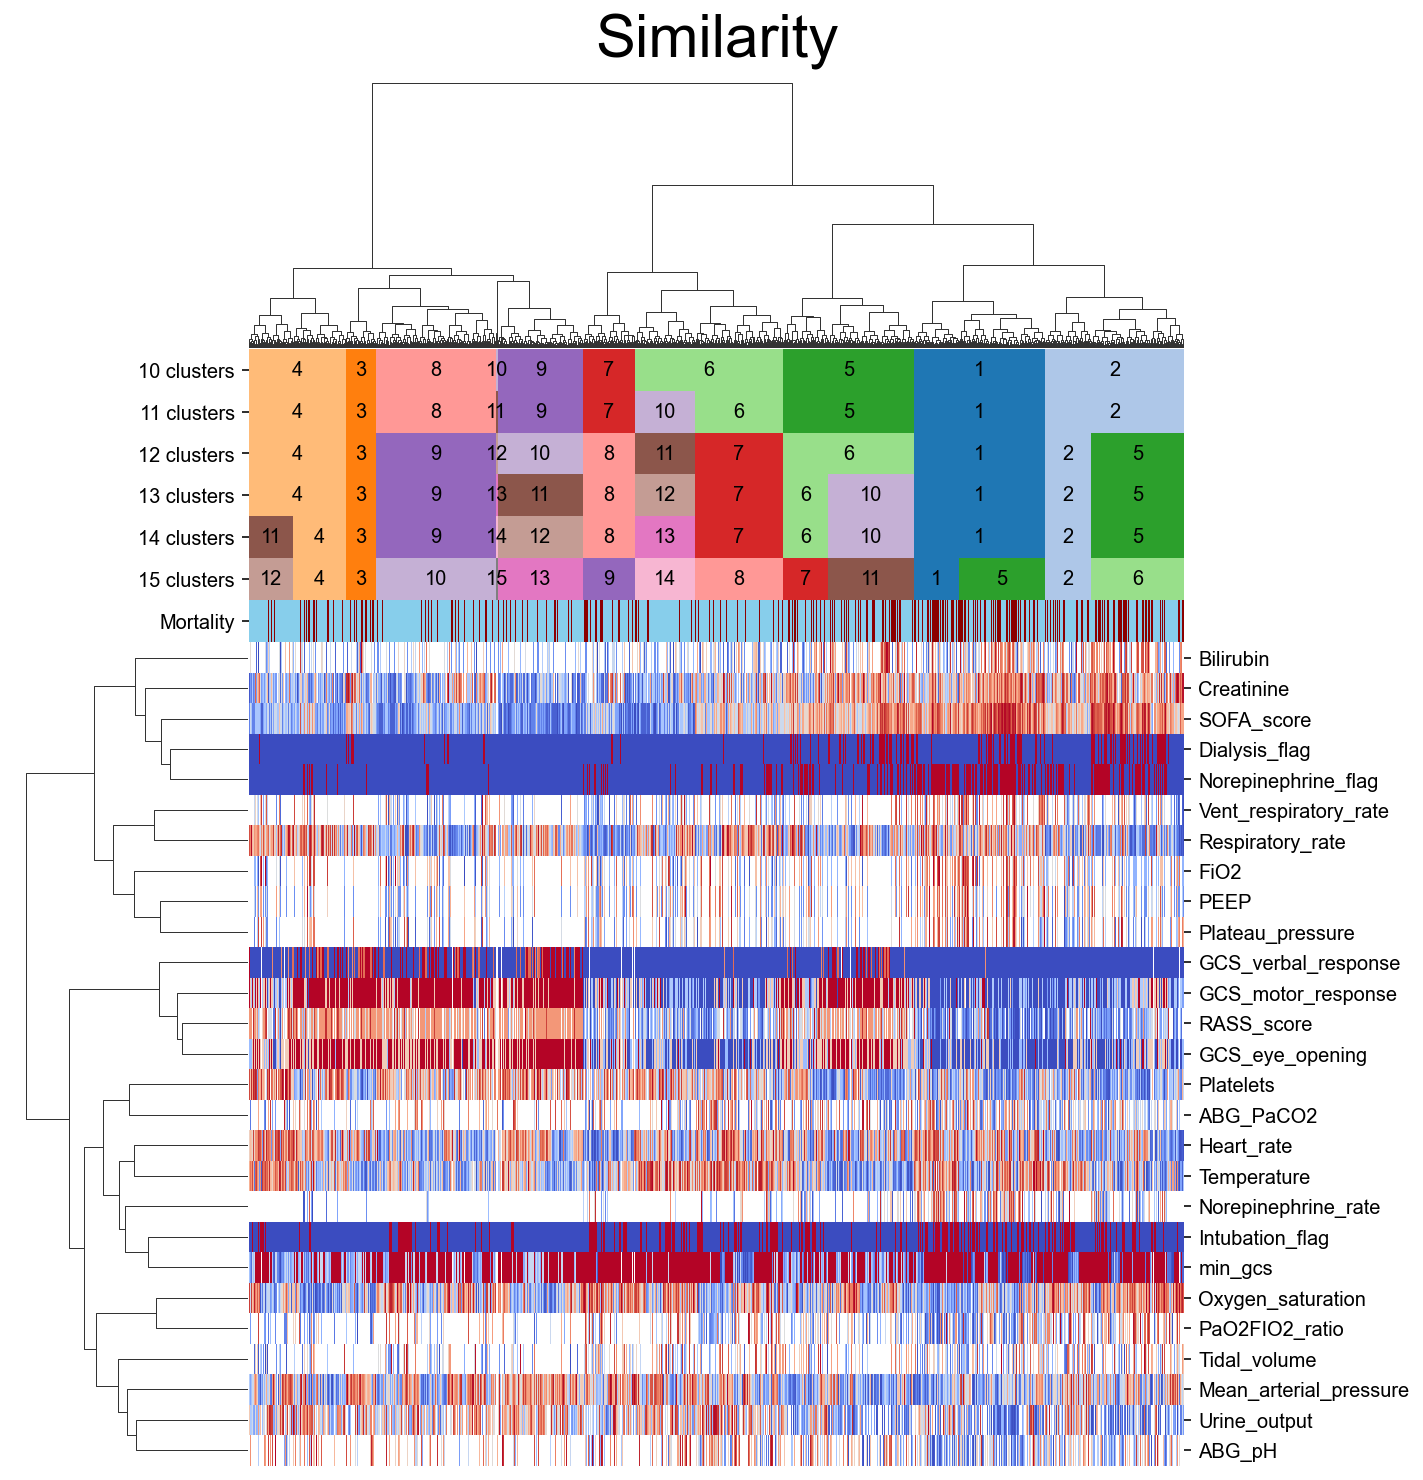

In [18]:
mpl.rcParams["figure.figsize"] = (10, 8)

for key in approaches.keys():
    clustering.heatmap(
        df_assigned_clusters=approaches[key]['assignments_table'], 
        df_with_mortality=data, 
        data_mtx=approaches[key]['feature_matrix'], 
        tree=approaches[key]['tree'], 
        col_tree=col_tree)
    plt.title(f'{key}\n\n\n\n\n\n\n\n\n', fontsize=30, loc='center')
        
    dump_figure(
    f'heatmap-{key}.pdf')

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


KeyError: 'ICU_stay'

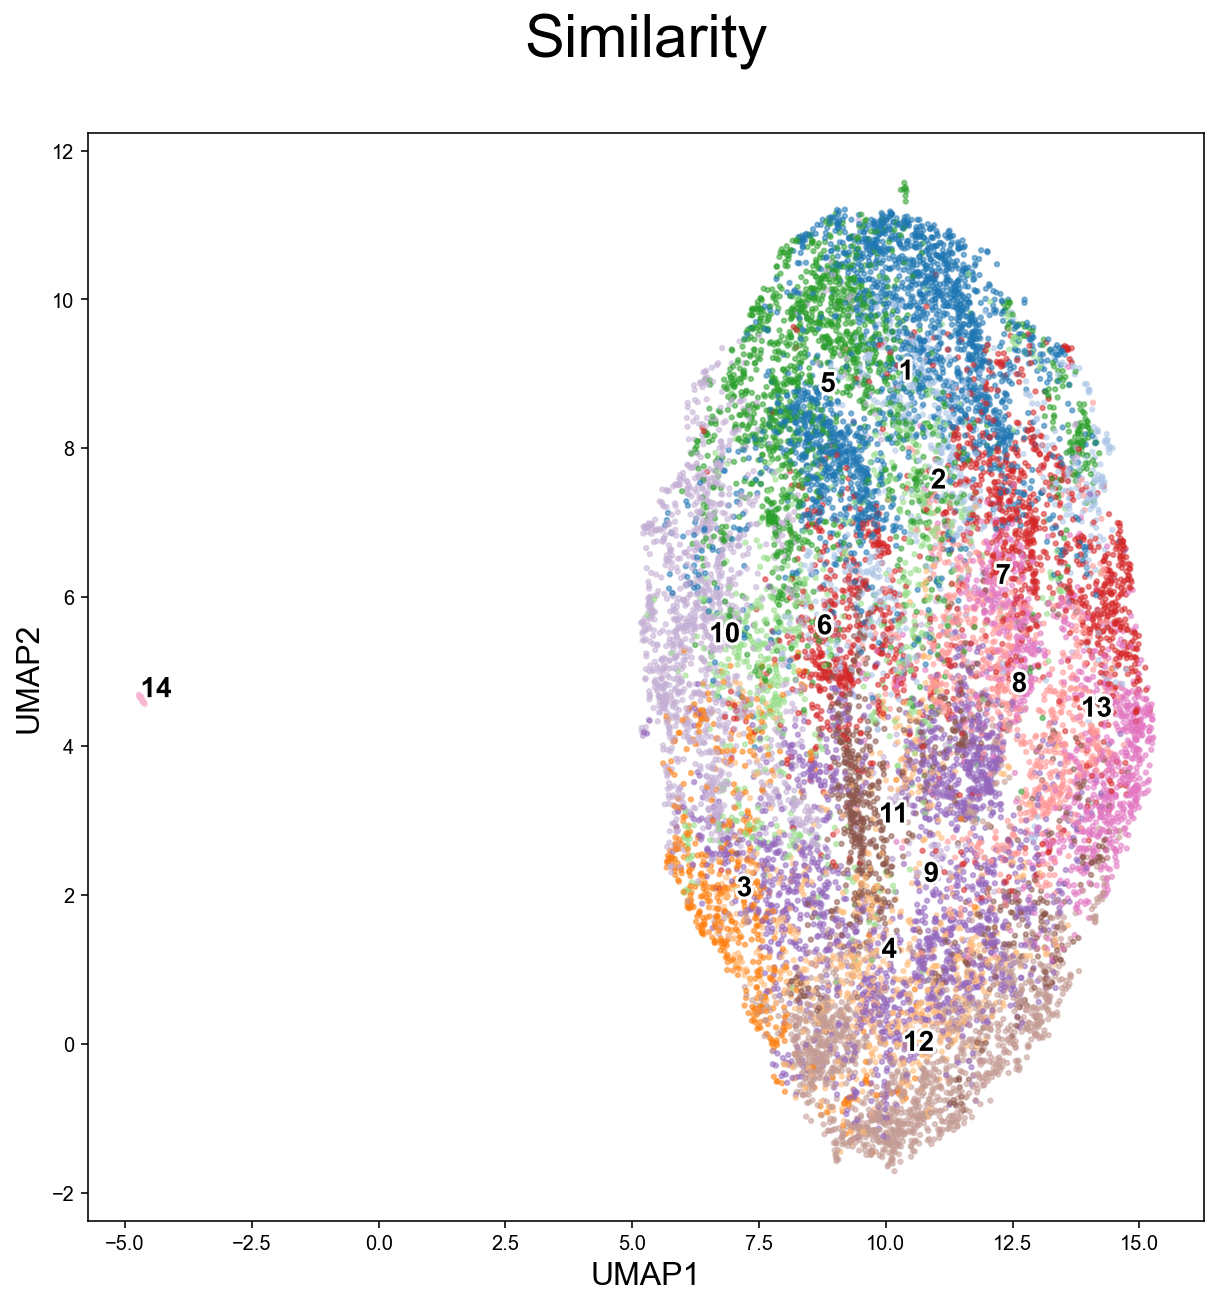

In [26]:
for key in approaches.keys():
    umap_data = clustering.show_umap(
    data=approaches[key]['data_dist'],
    assignment = approaches[key]['assignments'][14] )

    plt.title(f'{key}\n', fontsize=30, loc='center')
    
    #save umaps
    data["umap1"] = umap_data[:, 0]
    data["umap2"] = umap_data[:, 1]
    # data = clustering.index_by_patient_ids_icu_stay_day(data)
    dump_table(data, f'{key}-umap.csv.gz')
    
    dump_figure(
        f'umap-{key}.pdf')

In [20]:

def heatmap_by_mortality(data_with_mortality, data_mtx, assignment):

    
    data, cluster_mortality = clustering.infer_clustermortality_and_add_cluster_id(
        data_with_mortality, data_mtx, assignment)

    display(cluster_mortality)

    COLUMN_ORDER = [

        # // Sedation
    'RASS_score',
           'GCS_verbal_response', 'GCS_motor_response', 'GCS_eye_opening',

        # // Lung injury severity

        'Intubation_flag',
               'PaO2FIO2_ratio', 
        'FiO2', 'PEEP', 'Vent_respiratory_rate',
        'Plateau_pressure', 
        'Oxygen_saturation',
        'Respiratory_rate', 

        # // Hemodynamics/shock
         'Norepinephrine_rate',
         'Mean_arterial_pressure',
          'ABG_pH', 'ABG_PaCO2', 
        'Norepinephrine_flag',

        # // Renal
        'Dialysis_flag', 
        'Urine_output', 'Creatinine', 
        #other labs
        'Bilirubin', 'Platelets',
        
        #vitals
        'Temperature','Heart_rate', 
                
    ];


    df_color = pd.DataFrame(data.cluster_order.apply(
        lambda x: mpl.colors.rgb2hex(mpl.cm.tab20(int(x)))
    ))

    df_color['Binary_outcome'] = data.Binary_outcome.map(
        {0: "skyblue", 1: "darkred"}
    )

    mpl.rcParams["figure.figsize"] = (16, 16)
    cg = sns.clustermap(
        data_mtx.loc[data.index, COLUMN_ORDER].T, 
        col_cluster=False,
        row_cluster=False,
        col_colors=df_color.to_numpy().T,
        xticklabels=False,
        yticklabels=[x.replace("_", " ") for x in COLUMN_ORDER],
        cmap="coolwarm",
        cbar_pos=(0.07, 0.16, 0.015, 0.05),
        cbar_kws={"ticks": []},
        vmin=0,
        vmax=1,
        colors_ratio=0.025,
        standard_scale="row"
    )
    cg.ax_heatmap.collections[0].set_rasterized(True)
    cg.ax_col_colors.collections[0].set_rasterized(True)
    mort_x = []
    for i, (c, x) in enumerate(data.cluster_order.reset_index().reset_index()
                 .groupby("cluster_order").level_0.mean().iteritems()):
        cg.ax_col_colors.text(x, 0.4, str(i + 1), ha="center", va="center", size=14)
        mort_x.append(x)
    cg.ax_col_colors.set_yticks([0.5, 1.5])
    cg.ax_col_colors.set_yticklabels(["Cluster", "Mortality"], size=12)
    # cg.ax_col_colors.set_title("Rank-Euclidean", size=16)
    cg.ax_col_colors.set_ylim(0, 2)
    cg.ax_heatmap.tick_params(
        labelleft=True, left=True, right=False, labelright=False, labelsize=13
    )
    p = cg.ax_heatmap.get_position()
    p.x0 += 0.1
    p.x1 += 0.1
    cg.ax_heatmap.set_position(p)
    p = cg.ax_col_colors.get_position()
    p.y0 += 0.01
    p.y1 += 0.01
    p.x0 += 0.1
    p.x1 += 0.1
    cg.ax_col_colors.set_position(p)
    cg.cax.annotate("row min.", (0, -0.1), va="top", annotation_clip=False, fontsize=12)
    cg.cax.annotate("row max.", (0, 1.1), va="bottom", annotation_clip=False, fontsize=12)
    # for y, (i, r) in enumerate(cluster_mortality.iterrows()):
    #     x = y // 8 * 2000
    #     y = 6 - y % 8 * 0.5
    #     cg.ax_col_colors.text(x, y, f"{int(i)}: {r[3]:.3f}")
    p = cg.ax_col_colors.get_position()
    mort_ax = cg.figure.add_axes((p.x0, p.y0 + 0.08, p.x1 - p.x0, 0.08))
    mort_ax.patch.set_visible(False)
    mort_ax.set_xlim(*cg.ax_heatmap.get_xlim())
    mort_ax.plot(mort_x, cluster_mortality.mortality, c="#999")
    mort_ax.scatter(mort_x, cluster_mortality.mortality, c="#999")
    mort_ax.set_ylim(0, 1)
    mort_ax.tick_params(bottom=False, labelbottom=False)
    mort_ax.set_ylabel("Mortality rate", size=12)
    mort_ax.spines[["bottom", "top", "right"]].set_visible(False)
    mort_ax.axhline(0, ls="--", c="#aaa")
    mort_ax.axhline(1, ls="--", c="#aaa")


index  Total  Died  mortality
cluster                               
11.0         0    463    54   0.116631
8.0          1    663    96   0.144796
3.0          2    374    61   0.163102
7.0          3    416    72   0.173077
10.0         4    300    53   0.176667
12.0         5    364    66   0.181319
6.0          6    554   120   0.216606
2.0          7    272    65   0.238971
5.0          8    369    89   0.241192
1.0          9    414   101   0.243961
9.0         10    363   107   0.294766
4.0         11    478   158   0.330544
0.0         12    683   230   0.336750
13.0        13     26    11   0.423077

CPU times: user 2.74 s, sys: 151 ms, total: 2.89 s
Wall time: 2.4 s


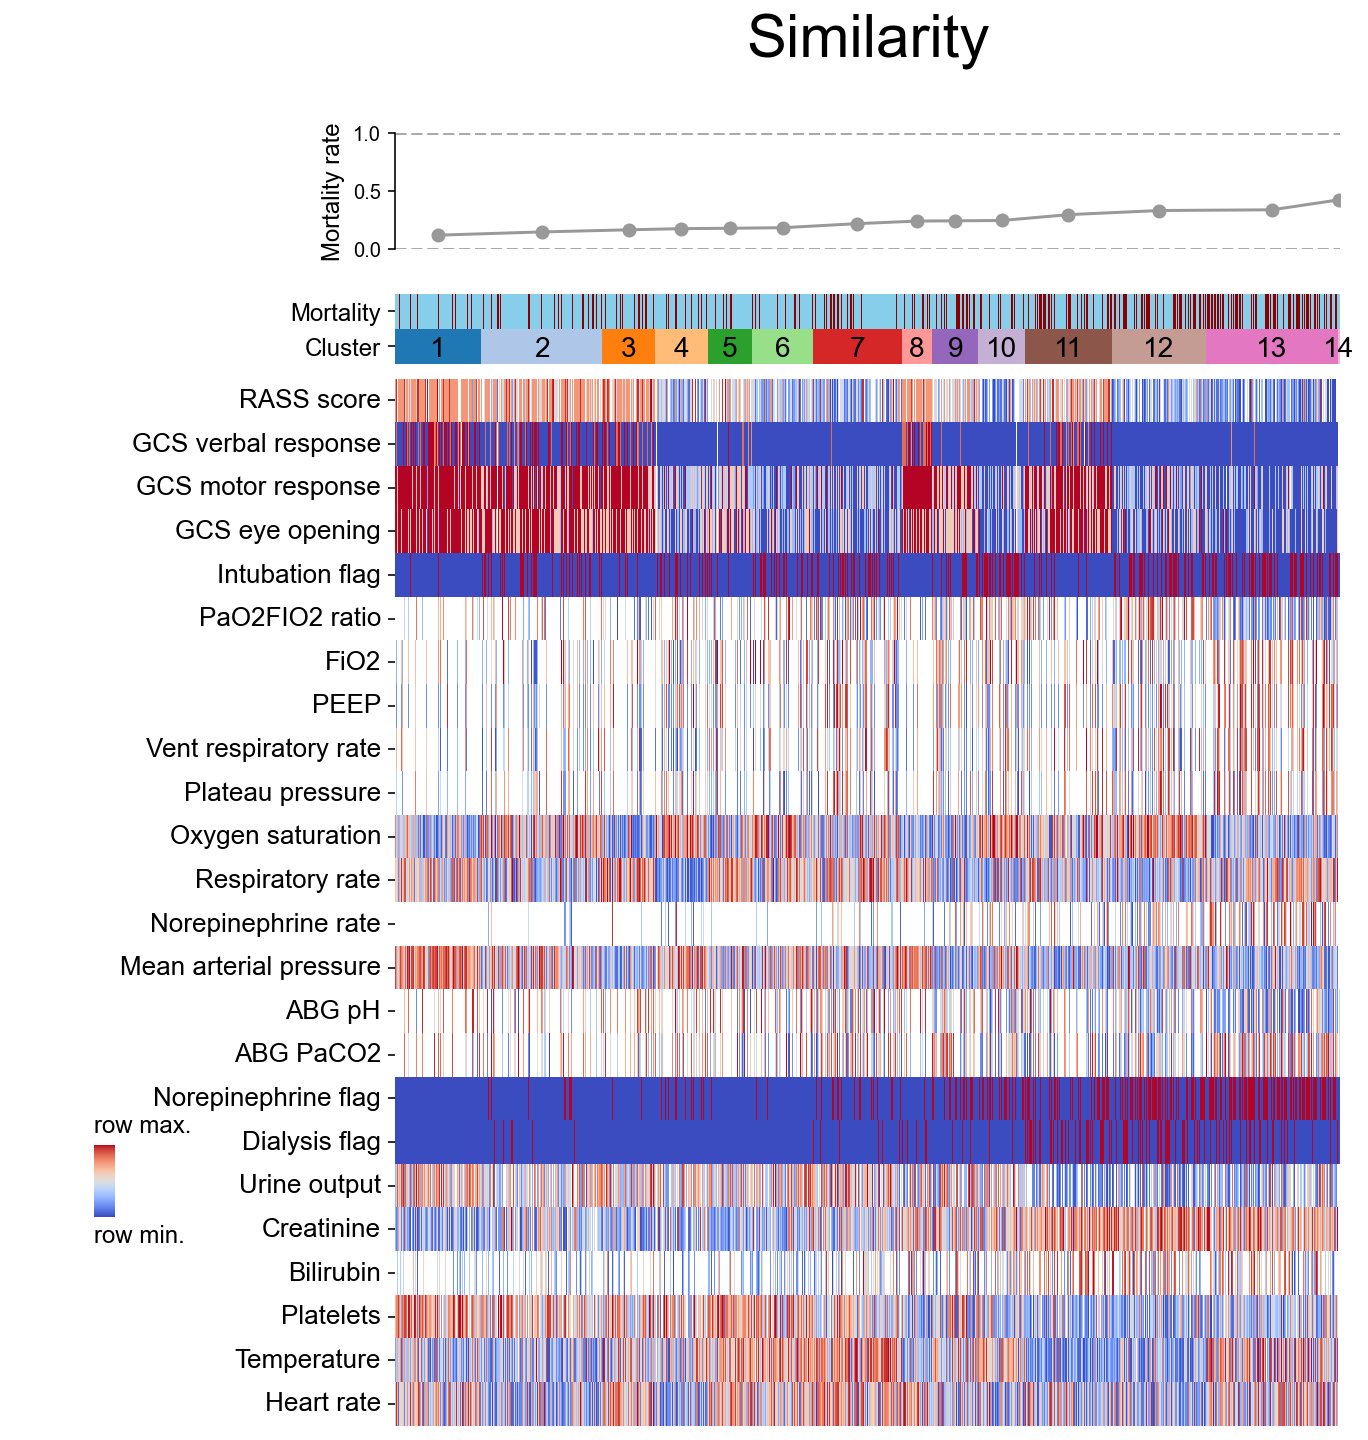

In [21]:
%%time    


for key in approaches.keys():
    
    heatmap_by_mortality(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )
    
    plt.title(f'{key}\n', fontsize=30, loc='center')
        
    dump_figure(
    f'manual_order-{key}.pdf')
    

In [22]:

def quilt4(data_with_mortality, data_mtx, assignment):


    data_mtx = data_mtx.copy()
    data = data_with_mortality.copy()
    assignment = assignment.copy()

    data, _ = clustering.infer_clustermortality_and_add_cluster_id(
        data_with_mortality, data_mtx, assignment)

    #data = data.loc[data_mtx.index] tried to troubleshoot why quilt2 doesn't work

    data.cluster = data.cluster_order + 1
    data.drop("cluster_order", axis="columns", inplace=True)

    # First element is name
    # Other elements are features with optional `-` in the beginning to flip their sign

    FEATURE_GROUPS = [
        ["Neurologic", '-RASS_score', '-GCS_eye_opening', '-GCS_motor_response', '-GCS_verbal_response'],
        ["Respiratory", 'Intubation_flag', '-PaO2FIO2_ratio', 'FiO2', 'PEEP', 
         '-Oxygen_saturation',  'Vent_respiratory_rate'],
        ["Shock", 'Norepinephrine_flag', 'Norepinephrine_rate', '-Mean_arterial_pressure',
        
        '-ABG_pH', 'ABG_PaCO2', 'Heart_rate', ],
        ["Renal", 'Dialysis_flag', 'Creatinine', '-Urine_output'],

    ]

        
    df = pd.DataFrame(0, index=data.index, columns=[x[0] for x in FEATURE_GROUPS])
    for group in FEATURE_GROUPS:
        for feature in group[1:]:
            sign = 1
            if feature.startswith("-"):
                sign = -1
                feature = feature[1:]
            idx = ~data_mtx[feature].isna()
            if feature in ("ECMO_flag", 'Intubation_flag', 'Hemodialysis_flag', 'CRRT_flag'):
                df.loc[idx, group[0]] += data.loc[idx, feature] * sign
            else:
                df.loc[idx, group[0]] += data_mtx.loc[idx, feature] * sign
            if f"{group[0]}_cnt" not in df.columns:
                df[f"{group[0]}_cnt"] = 0
            df.loc[idx, f"{group[0]}_cnt"] += 1

    # worst_resp, worst_resp_cnt = df.Respiratory.max(), df.Respiratory_cnt[df.Respiratory.idxmax()]
    # worst_renal, worst_renal_cnt = df.Renal.max(), df.Renal_cnt[df.Renal.idxmax()]
    # df.loc[data.ECMO_flag.eq(1), "Respiratory"] = worst_resp
    # df.loc[data.ECMO_flag.eq(1), "Respiratory_cnt"] = worst_resp_cnt
    # df.loc[data.Hemodialysis_flag.eq(1) | data.CRRT_flag.eq(1), "Renal"] = worst_renal
    # df.loc[data.Hemodialysis_flag.eq(1) | data.CRRT_flag.eq(1), "Renal_cnt"] = worst_renal_cnt
    quilt_df = pd.DataFrame(0, index=[x[0] for x in FEATURE_GROUPS], columns=sorted(data.cluster.unique()))


    for group in FEATURE_GROUPS:
        for c in quilt_df.columns:
            idx = data.index[data.cluster.eq(c)]
            quilt_df.loc[group[0], c] = df.loc[idx, group[0]].sum() / df.loc[idx, f"{group[0]}_cnt"].sum()
    cg = sns.clustermap(
        quilt_df,
        col_cluster=False,
        row_cluster=False,
        standard_scale="row",
        cmap="coolwarm",
        cbar_pos=(0.01, 0.38, 0.015, 0.05),
        cbar_kws={"ticks": []},
        vmin=0,
        vmax=1,
        linewidths=2,
    )
    cg.ax_heatmap.tick_params(
        bottom=False, 
        labelbottom=False, 
        top=True, 
        labeltop=True, 
        left=True,
        labelleft=True,
        right=False,
        labelright=False,
        labelsize=14
    )
    cg.ax_heatmap.set_xlabel("Cluster", size=16, labelpad=10)
    cg.ax_heatmap.xaxis.set_label_position("top")
    cg.cax.annotate("row min.", (0, -0.1), va="top", annotation_clip=False, fontsize=12)
    cg.cax.annotate("row max.", (0, 1.1), va="bottom", annotation_clip=False, fontsize=12)




/var/folders/1z/56frjt7x07l1yhz_hksrdcbm7wmsv2/T/ipykernel_6211/2817273950.py:59: RuntimeWarning: invalid value encountered in double_scalars
  quilt_df.loc[group[0], c] = df.loc[idx, group[0]].sum() / df.loc[idx, f"{group[0]}_cnt"].sum()


CPU times: user 884 ms, sys: 122 ms, total: 1.01 s
Wall time: 573 ms


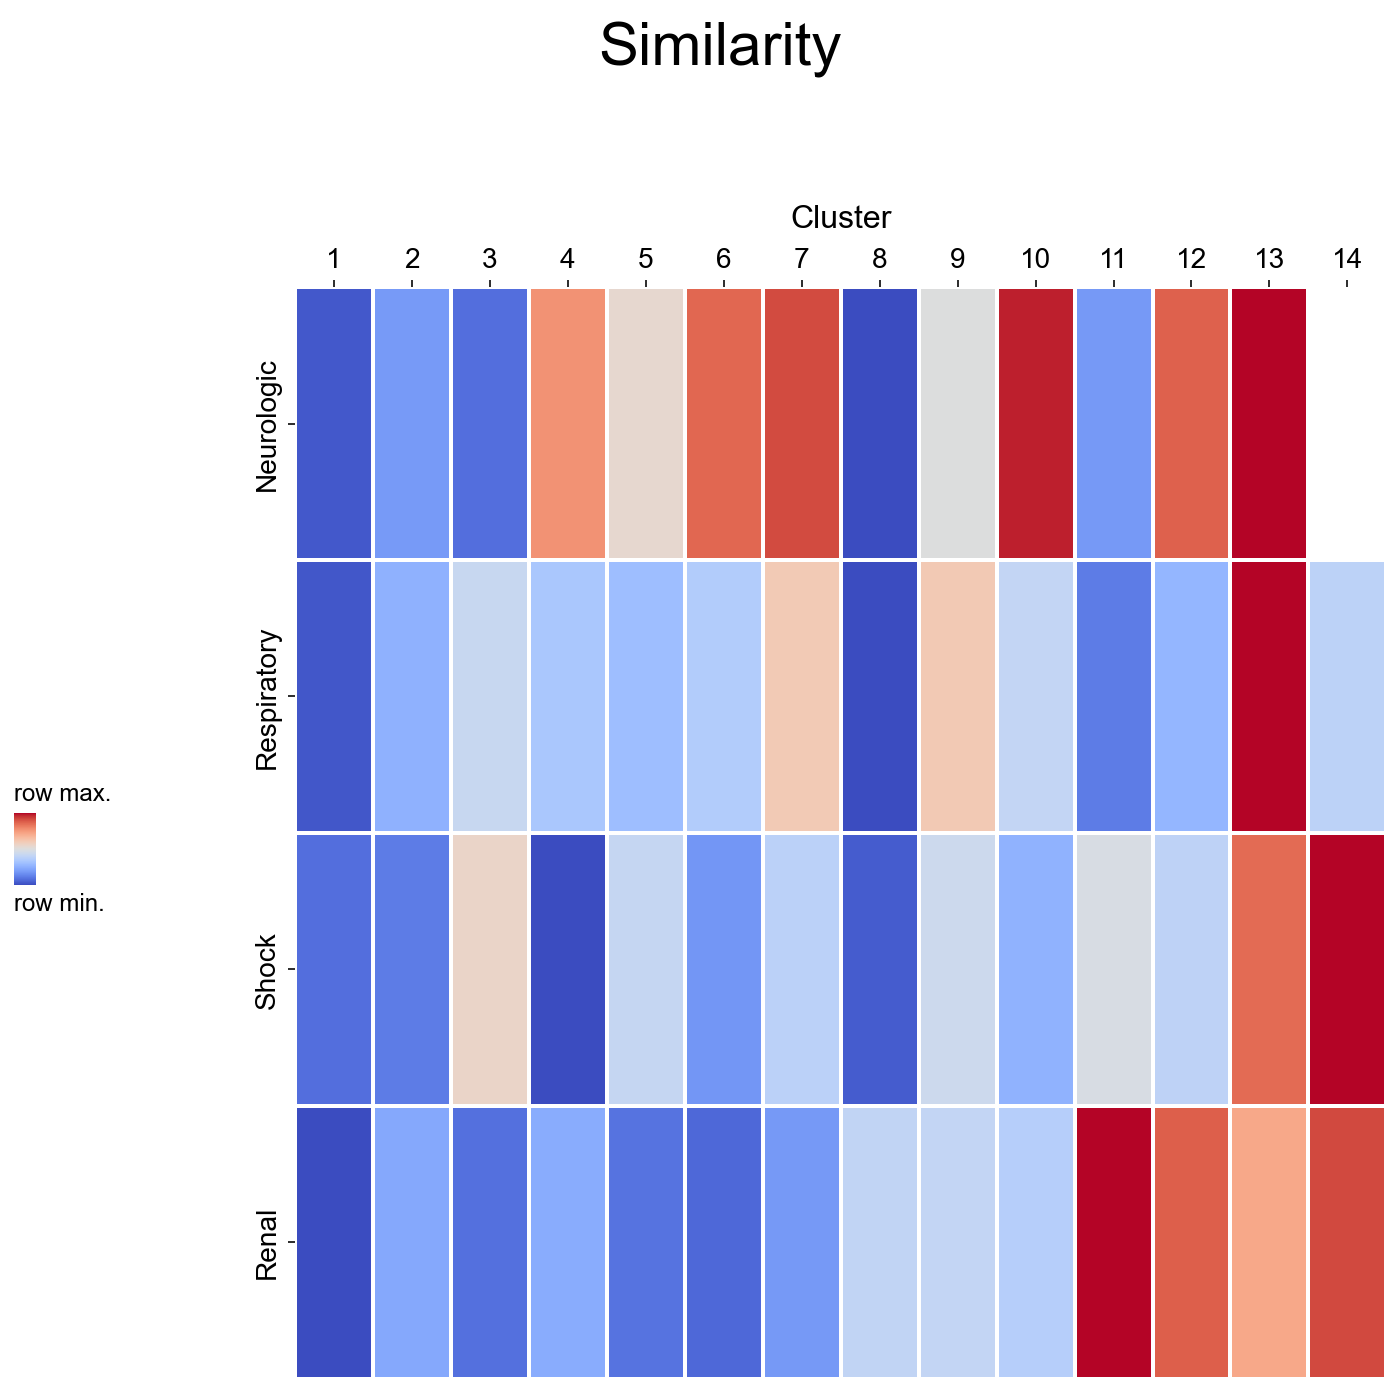

In [23]:
%%time    

for key in approaches.keys():
    
    quilt4(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt4-{key}.pdf')
    

In [24]:
data

Patient_id               intime              outtime        los  \
0        30061692  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
1        30061692  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
2        30061692  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
3        30061692  2192-03-18 04:51:00  2192-03-21 13:55:12   3.377917   
4        30117582  2192-07-02 02:48:54  2192-07-14 12:33:50  12.406204   
...           ...                  ...                  ...        ...   
15672    39918058  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743   
15673    39918058  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743   
15674    39918058  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743   
15675    39918058  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743   
15676    39918058  2159-06-25 16:26:17  2159-07-24 20:49:26  29.182743   

              day  day  Intubation_flag  Norepinephrine_rate  \
0      2192-03-18    1                1             0.200002   
1      2192-03-19    2                1             0.029934   
2      2192-03-20    3                0                  NaN   
3      2192-03-21    4                0                  NaN   
4      2192-07-02    1                1             0.251120   
...           ...  ...              ...                  ...   
15672  2159-07-20   26                0             0.077368   
15673  2159-07-21   27                0             0.069556   
15674  2159-07-22   28                0                  NaN   
15675  2159-07-23   29                0                  NaN   
15676  2159-07-24   30                0                  NaN   

       Mean_arterial_pressure  min_gcs  Urine_output  Bilirubin  Creatinine  \
0                        55.0     15.0           NaN        0.2         2.3   
1                        61.0     15.0   1606.779661        0.5         1.3   
2                        64.0     10.0   1630.000000        NaN         1.0   
3                        74.0     13.0   3396.923077        NaN         0.9   
4                        57.0     15.0           NaN        1.0         6.1   
...                       ...      ...           ...        ...         ...   
15672                    54.0     15.0           NaN        NaN         2.7   
15673                    56.0     15.0           NaN        NaN         3.1   
15674                    63.0     12.0           NaN        NaN         2.6   
15675                    29.0     15.0           NaN        NaN         2.9   
15676                    59.0     15.0           NaN        NaN         3.3   

       Platelets  SOFA_score  Dialysis_flag  FiO2   PEEP  \
0          284.0        10.0            0.0  54.0   9.54   
1          192.0        10.0            0.0  50.0  10.30   
2          121.0         7.0            0.0   NaN    NaN   
3          134.0         4.0            0.0   NaN    NaN   
4          150.0        11.0            1.0   NaN    NaN   
...          ...         ...            ...   ...    ...   
15672       80.0         8.0            0.0   NaN    NaN   
15673       83.0         7.0            1.0   NaN    NaN   
15674       74.0         9.0            0.0   NaN    NaN   
15675       81.0         7.0            0.0   NaN    NaN   
15676       84.0         5.0            1.0   NaN    NaN   

       Vent_respiratory_rate  Tidal_volume  avg_mv  Plateau_pressure  min_hr  \
0                       17.0         446.0    9.72              24.0    86.0   
1                       20.0         480.0    9.30              23.0    78.0   
2                        NaN           NaN     NaN               NaN    59.0   
3                        NaN           NaN     NaN               NaN    74.0   
4                        NaN           NaN     NaN               NaN    70.0   
...                      ...           ...     ...               ...     ...   
15672                    NaN           NaN     NaN               NaN    79.0   
15673                    NaN           

In [27]:
data[data.umap1<0] #all NAs, will drop


Patient_id               intime              outtime        los  \
771      36465592  2184-03-02 00:27:00  2184-04-14 03:17:10  43.118171   
1569     32621495  2185-08-28 21:38:38  2185-09-07 20:56:52   9.970995   
2207     38061142  2181-02-24 23:20:31  2181-03-08 05:41:08  11.264317   
2229     38362310  2164-02-25 22:52:16  2164-03-01 19:52:52   4.875417   
4813     31089159  2159-04-12 23:49:00  2159-04-21 20:52:45   8.877604   
5616     37996113  2188-07-06 23:38:00  2188-07-14 21:25:55   7.908275   
7686     37629882  2180-01-18 23:16:32  2180-02-01 13:55:59  13.610729   
7894     39308220  2124-06-17 03:16:53  2124-06-23 03:31:47   6.010347   
8539     33527420  2128-11-01 23:47:38  2128-11-04 15:31:57   2.655775   
8951     36924726  2166-12-03 00:46:00  2166-12-11 01:54:44   8.047731   
9222     39361421  2166-04-15 23:59:00  2166-04-26 23:58:53  10.999919   
9370     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9371     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9372     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9373     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9374     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9375     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9376     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9377     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9378     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9379     39266377  2158-03-17 12:55:31  2158-04-01 16:15:35  15.138935   
9453     37469583  2130-10-18 23:45:44  2130-11-04 02:07:27  16.098414   
9831     34328793  2173-05-02 20:40:30  2173-05-04 16:02:36   1.807014   
11036    31773658  2127-07-12 23:48:00  2127-07-18 23:26:53   5.985336   
11773    32942286  2170-04-02 23:43:28  2170-04-05 02:05:21   2.098530   
11776    33144981  2160-06-11 23:25:00  2160-07-16 18:11:31  34.782303   
11841    33712385  2121-02-17 22:28:44  2121-03-01 15:49:14  11.722569   
12158    38573166  2154-02-09 22:51:56  2154-03-14 18:17:52  32.809676   
12209    39164071  2151-06-01 21:35:28  2151-06-13 13:21:34  11.657014   
13179    32004882  2128-03-10 02:37:00  2128-03-16 04:00:26   6.057940   
13482    37520476  2192-07-29 23:37:00  2192-08-07 11:32:09   8.496632   
14461    33859161  2188-09-08 23:56:39  2188-10-04 07:53:53  25.331412   
15292    36088584  2152-03-25 21:44:36  2152-04-10 23:06:38  16.056968   
15417    37104426  2180-06-13 22:13:25  2180-06-27 16:39:38  13.768206   
15538    38690919  2191-09-15 23:44:17  2191-11-09 19:59:22  54.843808   

              day  day  Intubation_flag  Norepinephrine_rate  \
771    2184-04-14   44                0                  NaN   
1569   2185-08-28    1                0                  NaN   
2207   2181-02-24    1                0                  NaN   
2229   2164-02-25    1                0                  NaN   
4813   2159-04-12    1                0                  NaN   
5616   2188-07-06    1                0                  NaN   
7686   2180-01-18    1                0                  NaN   
7894   2124-06-23    7                0                  NaN   
8539   2128-11-01    1                0                  NaN   
8951   2166-12-11    9                0                  NaN   
9222   2166-04-15    1                0                  NaN   
9370   2158-03-23    7                0                  NaN   
9371   2158-03-24    8                0                  NaN   
9372   2158-03-25    9                0                  NaN   
9373   2158-03-26   10                0                  NaN   
9374   2158-03-27   11                0                  NaN   
9375   2158-03-28   12                0                  NaN   
9376   2158-03-29   13                0                  NaN   
9377   2158-03-30   14                0                  NaN   
9378   2158-03-31   15                0                  NaN  

In [28]:
data = data[data.umap1>0].copy().reset_index()

In [29]:
data.shape

(15642, 43)

CPU times: user 9min 1s, sys: 14 s, total: 9min 15s
Wall time: 7min 51s


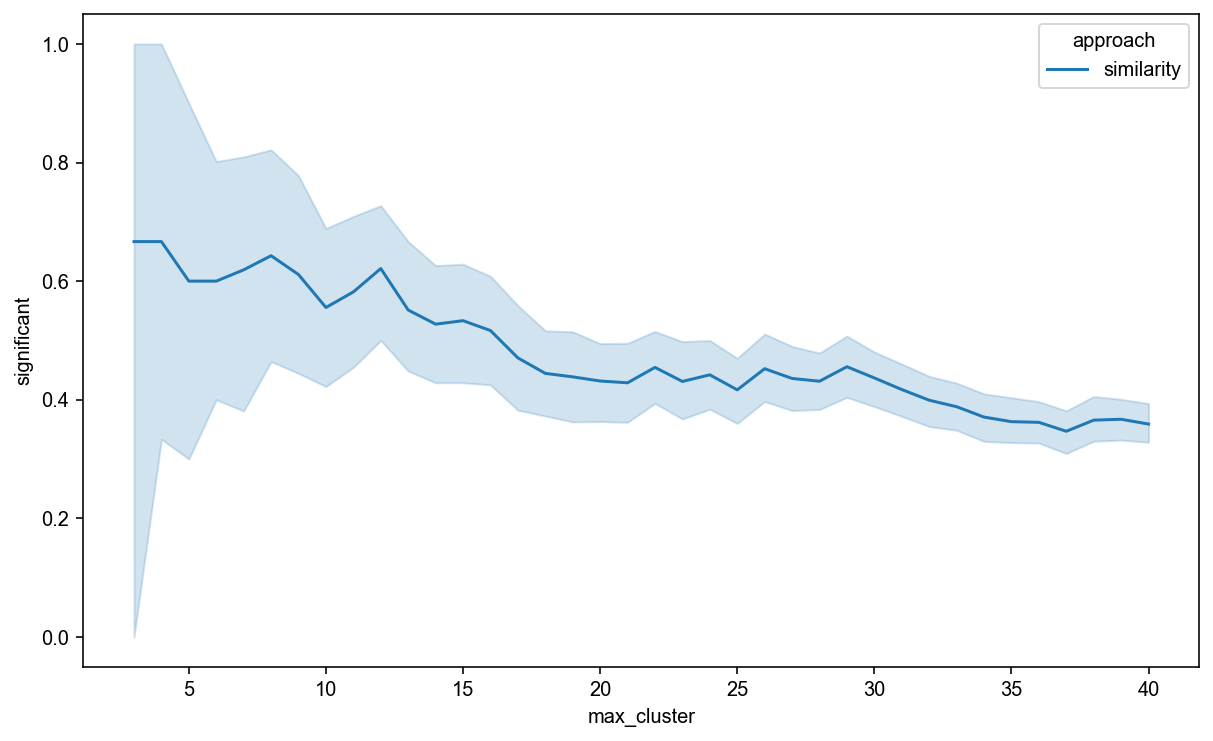

In [30]:
%%time

data_mtx = data[data_columns].copy()
data_mtx = data_mtx.rank(axis=0, pct=True)
data_dist_col = clustering.get_distances(data_mtx.transpose(), approach='nan_euclidean')   
col_tree = clustering.get_tree(data_dist_col, approach='ward')
cutoff_groups = clustering.identify_related_features(data[data_columns])
threshold_for_relatedness = 0.7
data_mtx = clustering.reweight_related_features(
    data_mtx, 
    approach='square_root', 
    groups=cutoff_groups[threshold_for_relatedness])

data_mtx_for_similarity = data_mtx.copy()
data_mtx_for_similarity = clustering.reweight_related_features(
    data_mtx_for_similarity, 
    approach='mean_rank', 
    groups=cutoff_groups[threshold_for_relatedness])


#1. Similarity approach
corr_mtx = data_mtx_for_similarity.transpose().corr("pearson")
data_dist = clustering.get_distances(corr_mtx, approach='euclidean')   
tree = clustering.get_tree(df_dist=data_dist, approach='ward')
out, assignments = clustering.table_with_assignments(
    tree=tree,
    labels=data.index
)
sign_mortality_similarity = clustering.get_sign_mortalities(
    df_assigned_clusters=out,
    df_with_mortality=data
)
sign_mortality_similarity.loc[:, 'approach'] = 'similarity'


out, assignments = clustering.table_with_assignments(
    tree=tree,
    labels=data.index
)
sign_mortality_similarity = clustering.get_sign_mortalities(
    df_assigned_clusters=out,
    df_with_mortality=data
)
sign_mortality_similarity.loc[:, 'approach'] = 'similarity'
mpl.rcParams["figure.figsize"] = (10, 6)
sns.lineplot(
    x='max_cluster',
    y='significant',
    data=sign_mortality_similarity.reset_index(),
    hue='approach'
)
dump_figure('approaches_significance.pdf')

In [31]:
#store in dictionary
approaches = {
    'Similarity' : {
        'feature_matrix':data_mtx,
        'data_dist':data_dist,
        'tree':tree,
        'assignments_table':out,
        'assignments':assignments
    },
    # 'Ranked-Euclidean' : {
    #     'feature_matrix':data_mtx,
    #     'data_dist':rank_data_dist,
    #     'tree':rank_tree,
    #     'assignments_table':rank_out,
    #     'assignments':rank_assignments
    # },
    # 'Normalized-Euclidean' : {
    #     'feature_matrix':data_mtx,
    #     'data_dist':norm_data_dist,
    #     'tree':norm_tree,
    #     'assignments_table':norm_out,
    #     'assignments':norm_assignments
    # }
}

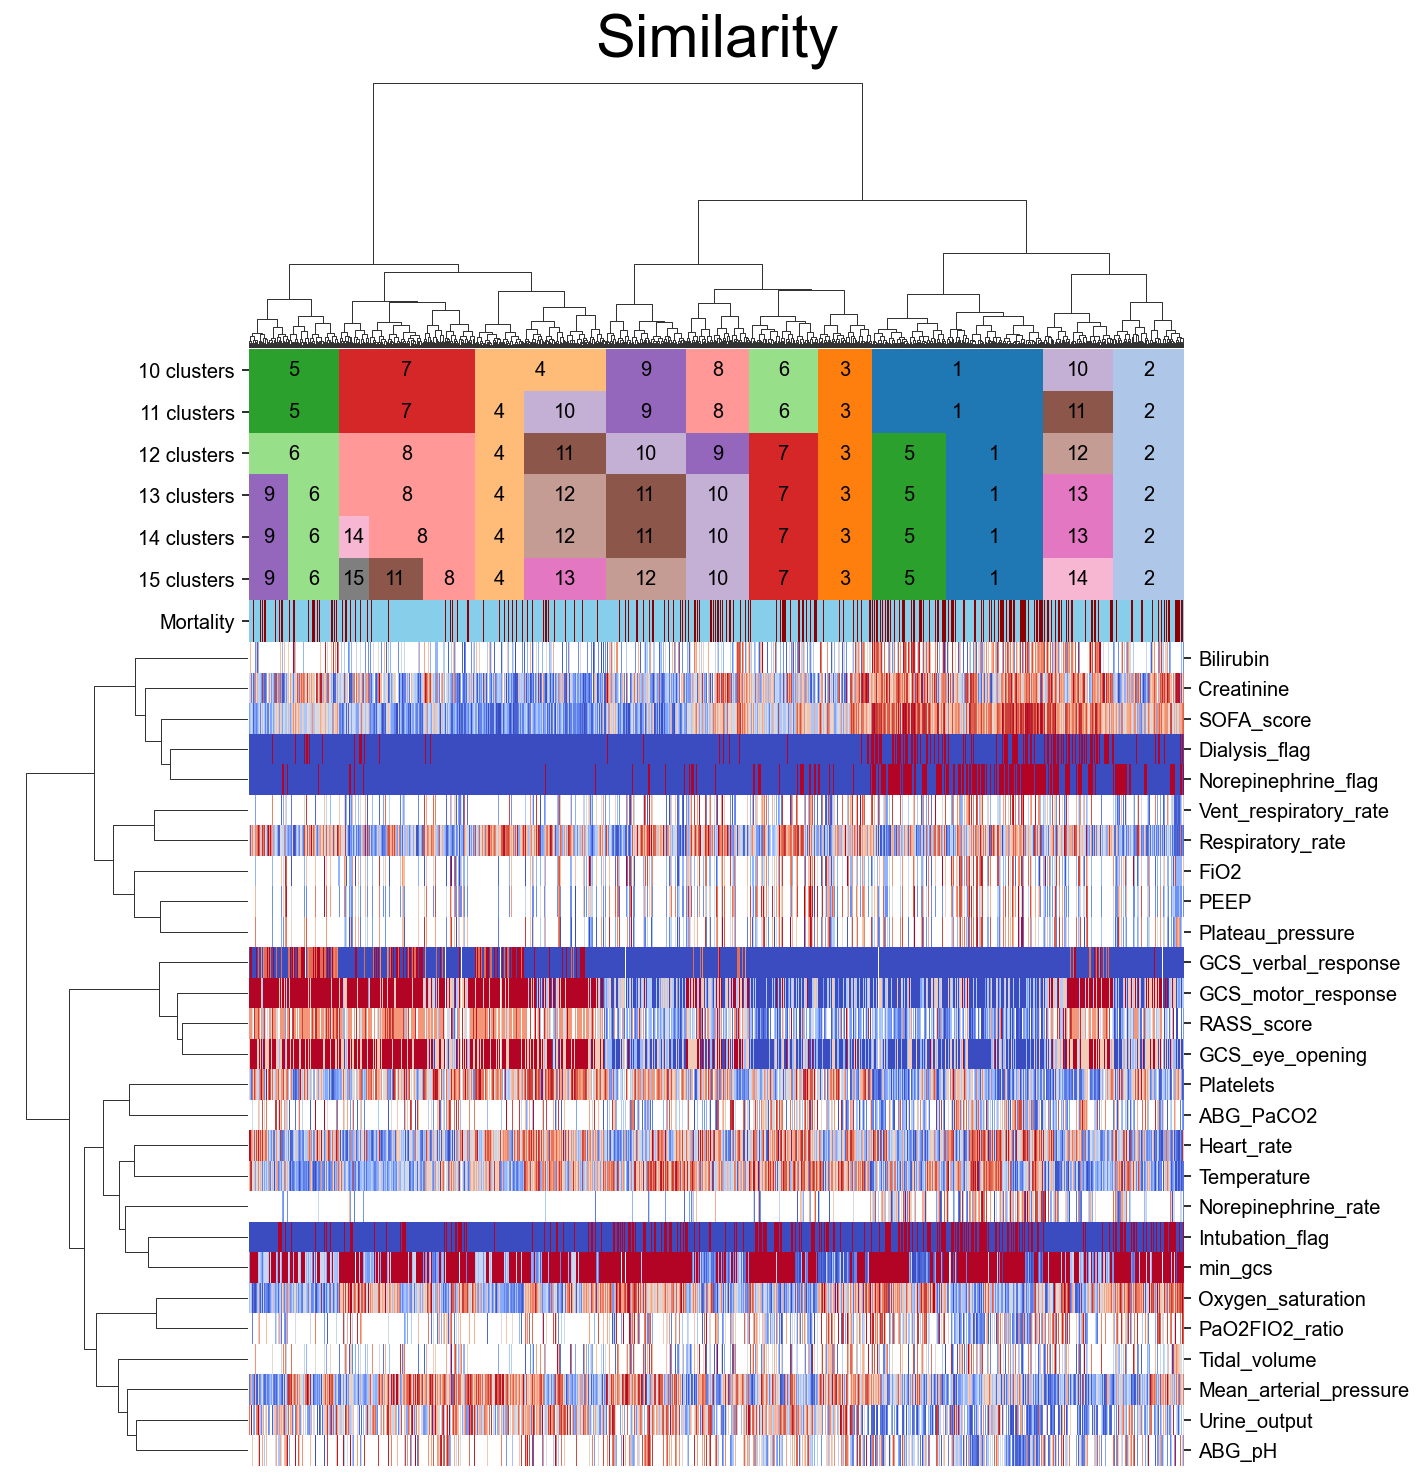

In [32]:
mpl.rcParams["figure.figsize"] = (10, 8)

for key in approaches.keys():
    clustering.heatmap(
        df_assigned_clusters=approaches[key]['assignments_table'], 
        df_with_mortality=data, 
        data_mtx=approaches[key]['feature_matrix'], 
        tree=approaches[key]['tree'], 
        col_tree=col_tree)
    plt.title(f'{key}\n\n\n\n\n\n\n\n\n', fontsize=30, loc='center')
        
    dump_figure(
    f'heatmap-{key}.pdf')

index  Total  Died  mortality
cluster                               
7.0          0    650    82   0.126154
11.0         1    409    52   0.127139
3.0          2    328    43   0.131098
13.0         3    227    40   0.176211
10.0         4    480    89   0.185417
8.0          5    308    59   0.191558
9.0          6    504   108   0.214286
2.0          7    382    84   0.219895
1.0          8    538   122   0.226766
5.0          9    370    88   0.237838
6.0         10    436   105   0.240826
12.0        11    303    97   0.320132
0.0         12    584   200   0.342466
4.0         13    384   143   0.372396

CPU times: user 2.66 s, sys: 161 ms, total: 2.82 s
Wall time: 2.33 s


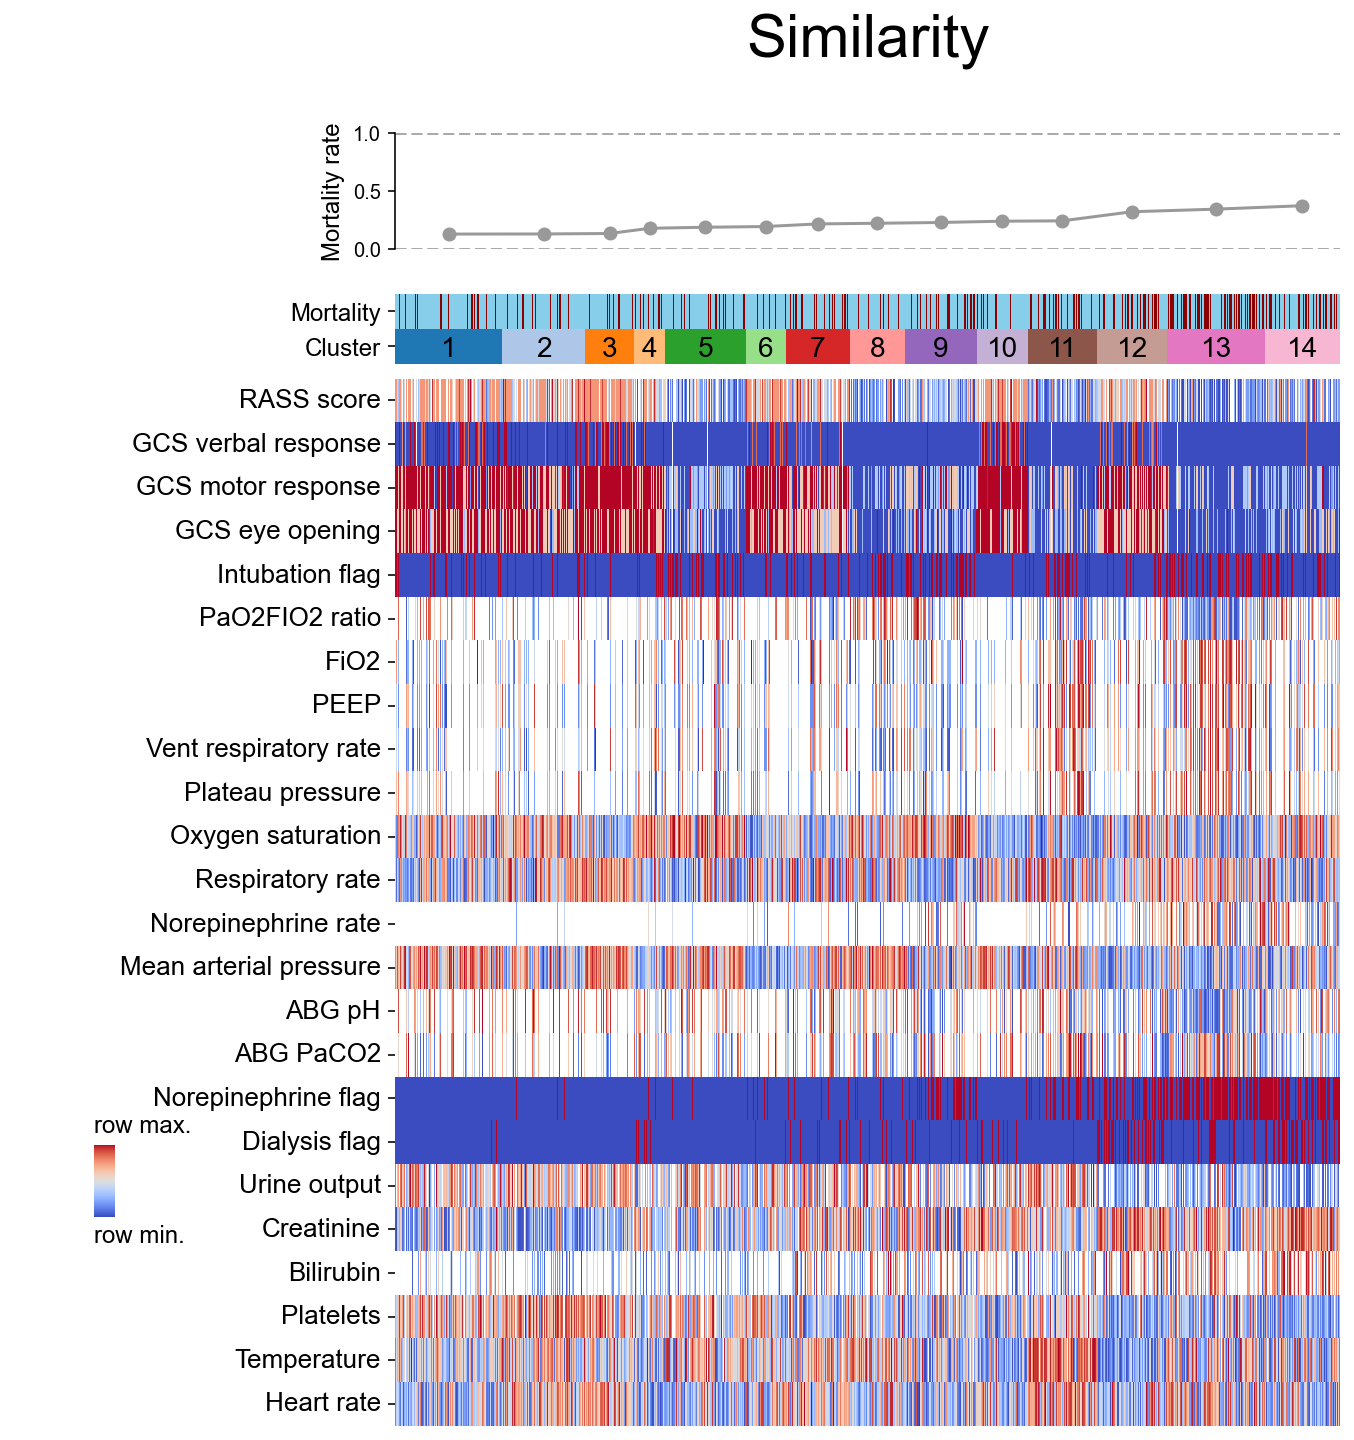

In [33]:
%%time    


for key in approaches.keys():
    
    heatmap_by_mortality(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )
    
    plt.title(f'{key}\n', fontsize=30, loc='center')
        
    dump_figure(
    f'manual_order-{key}.pdf')
    

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


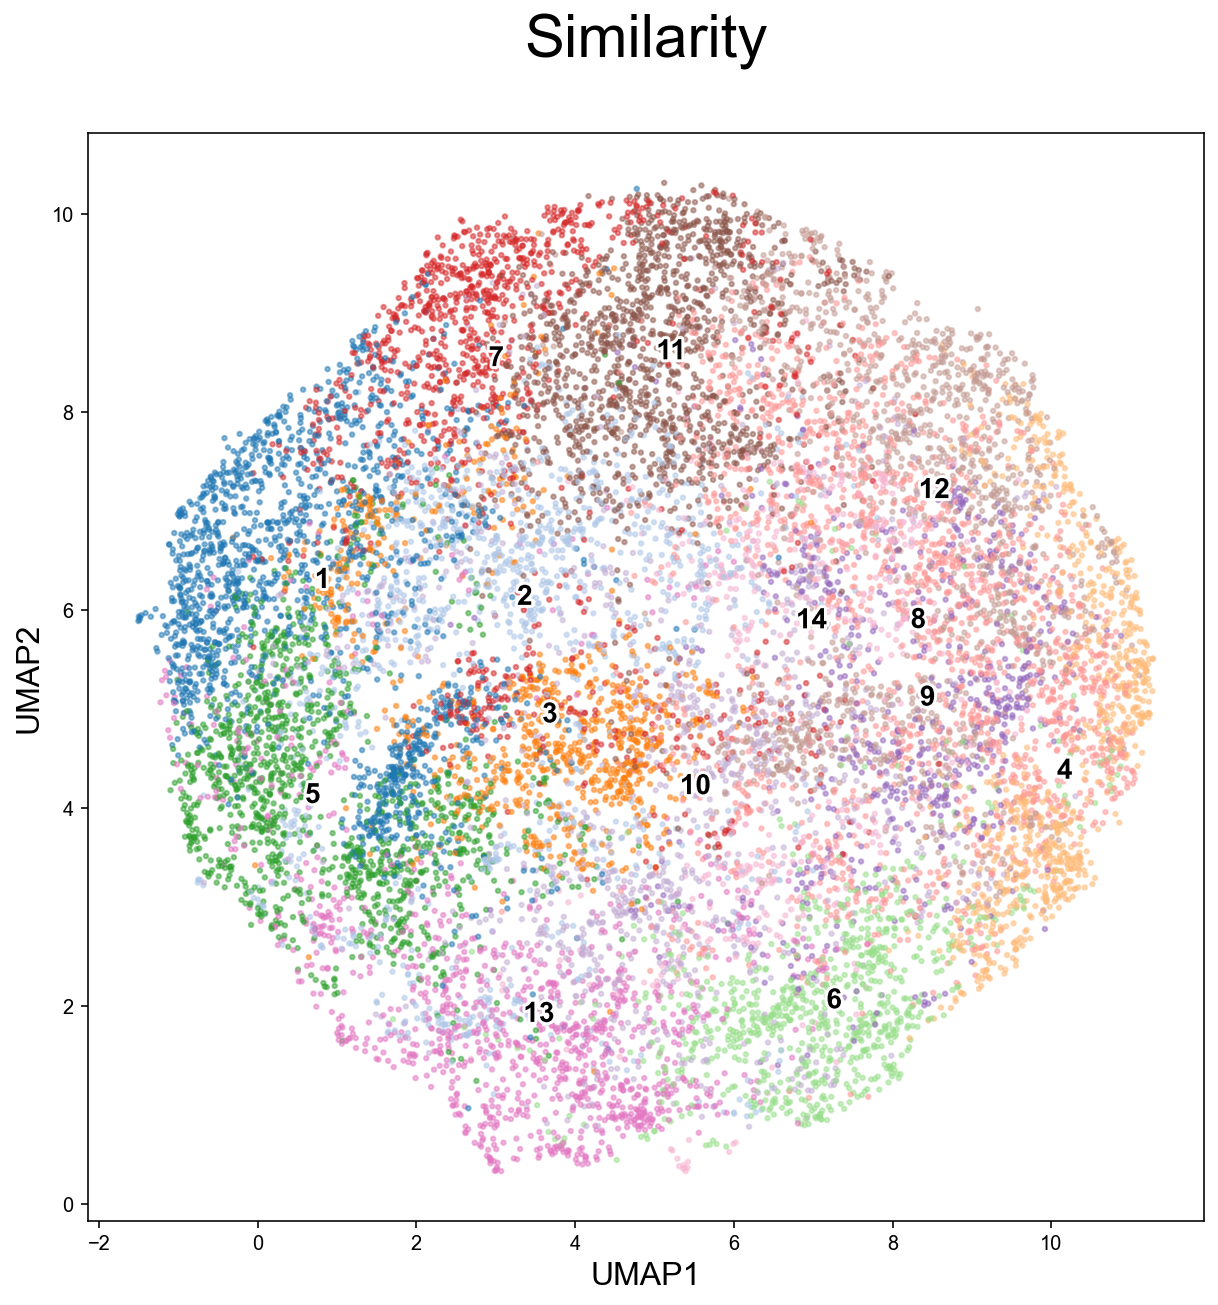

In [43]:
for key in approaches.keys():
    umap_data = clustering.show_umap(
    data=approaches[key]['data_dist'],
    assignment = approaches[key]['assignments'][14] )

    plt.title(f'{key}\n', fontsize=30, loc='center')
    
    # #save umaps
    # data["umap1"] = umap_data[:, 0]
    # data["umap2"] = umap_data[:, 1]
    # data = clustering.index_by_patient_ids_icu_stay_day(data)
    # dump_table(data, f'{key}-umap.csv.gz')
    
    dump_figure(
        f'umap-{key}.pdf')

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/sklearn/manifold/_spectral_embedding.py:369: UserWarning: Exited at iteration 335 with accuracies 

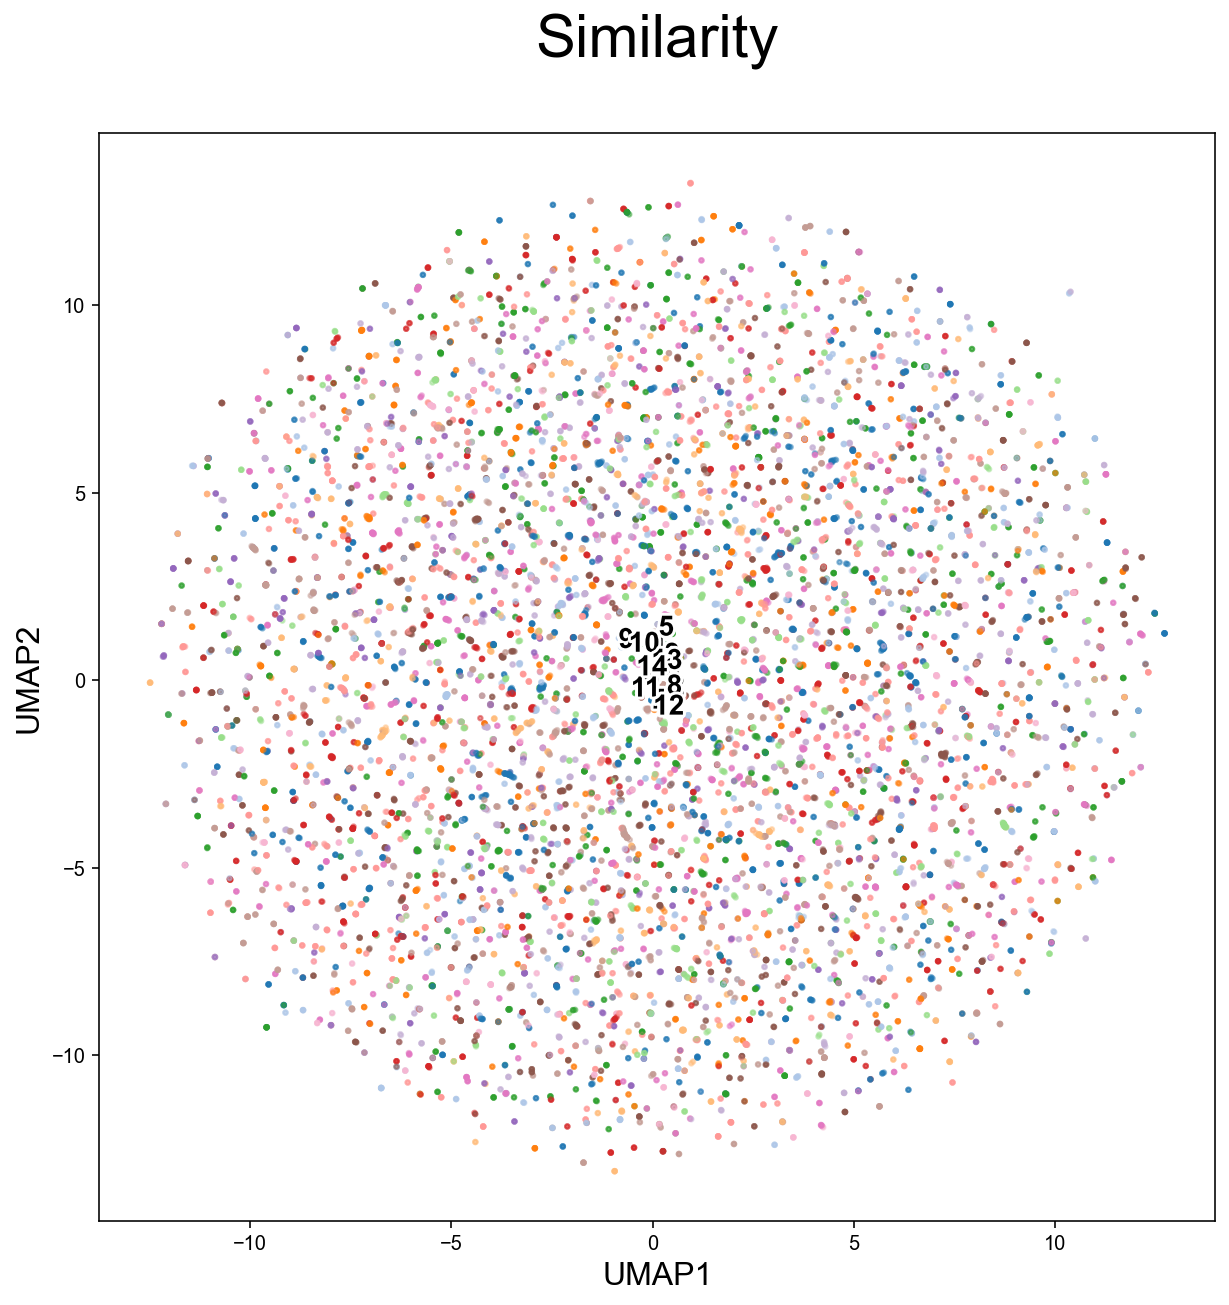

In [47]:
for key in approaches.keys():
    umap_data = clustering.show_umap2(
    data=approaches[key]['data_dist'],
    assignment = approaches[key]['assignments'][14] )

    plt.title(f'{key}\n', fontsize=30, loc='center')
    
    # #save umaps
    # data["umap1"] = umap_data[:, 0]
    # data["umap2"] = umap_data[:, 1]
    # data = clustering.index_by_patient_ids_icu_stay_day(data)
    # dump_table(data, f'{key}-umap.csv.gz')
    
    dump_figure(
        f'umap2-{key}.pdf')

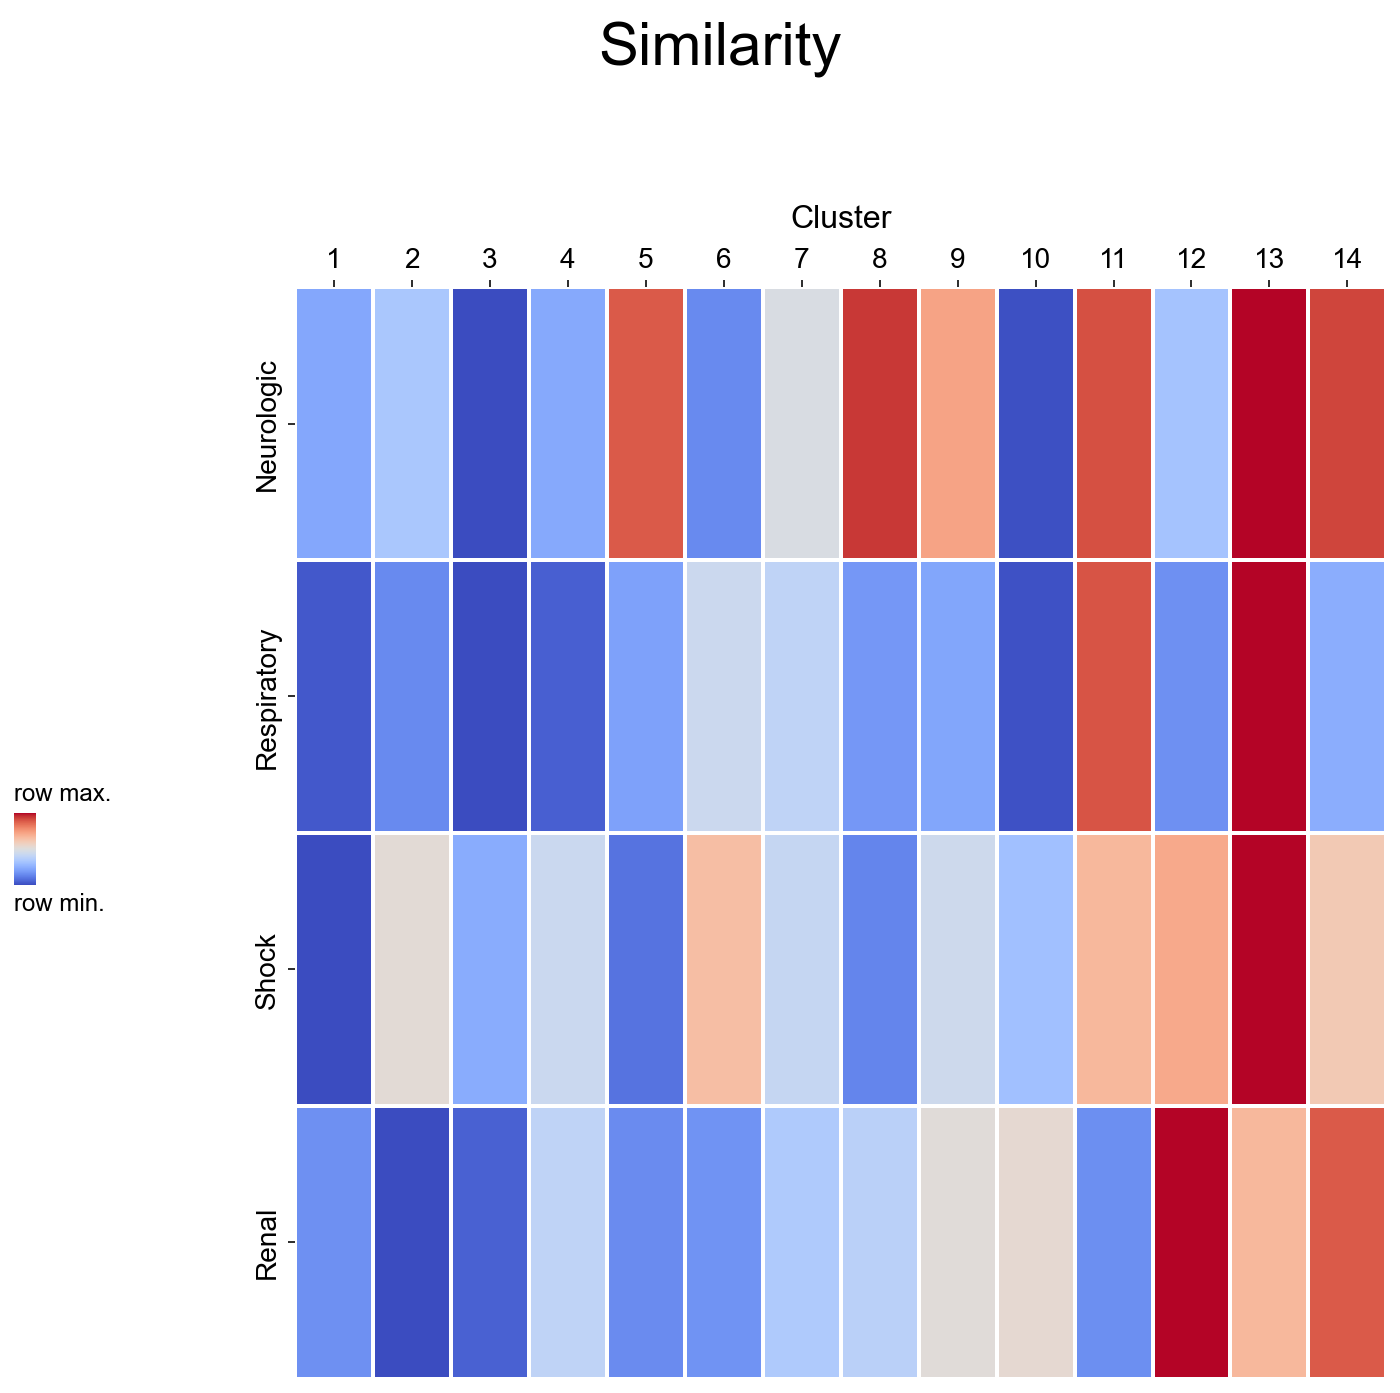

In [42]:
for key in approaches.keys():
    
    quilt4(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][14]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt4-{key}.pdf')
    

index  Total  Died  mortality
cluster                               
10.0         0    409    52   0.127139
3.0          1    328    43   0.131098
7.0          2    728   103   0.141484
9.0          3    480    89   0.185417
8.0          4    504   108   0.214286
5.0          5    578   124   0.214533
2.0          6    382    84   0.219895
1.0          7    538   122   0.226766
6.0          8    436   105   0.240826
11.0         9    303    97   0.320132
0.0         10    584   200   0.342466
4.0         11    384   143   0.372396

CPU times: user 2.61 s, sys: 177 ms, total: 2.78 s
Wall time: 3.85 s


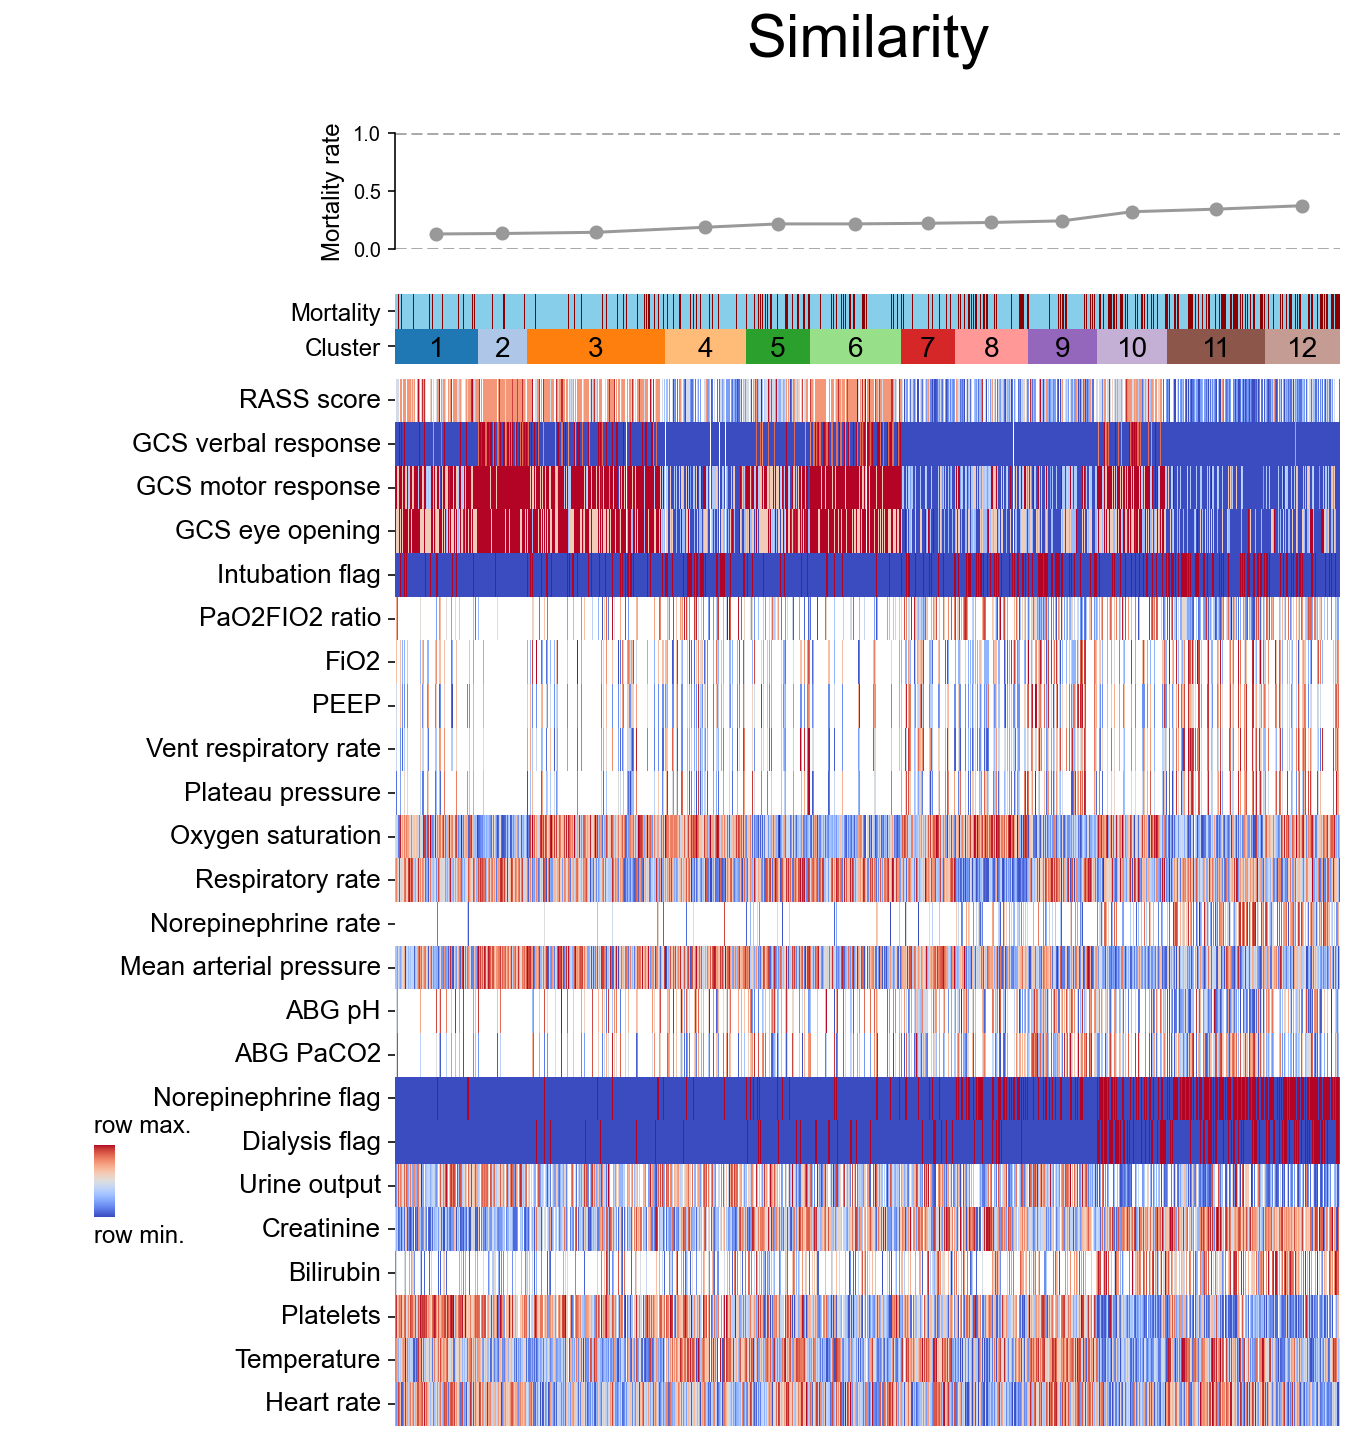

In [48]:
%%time    


for key in approaches.keys():
    
    heatmap_by_mortality(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][12]
        )
    
    plt.title(f'{key}\n', fontsize=30, loc='center')
        
    dump_figure(
    f'manual_order12-{key}.pdf')
    

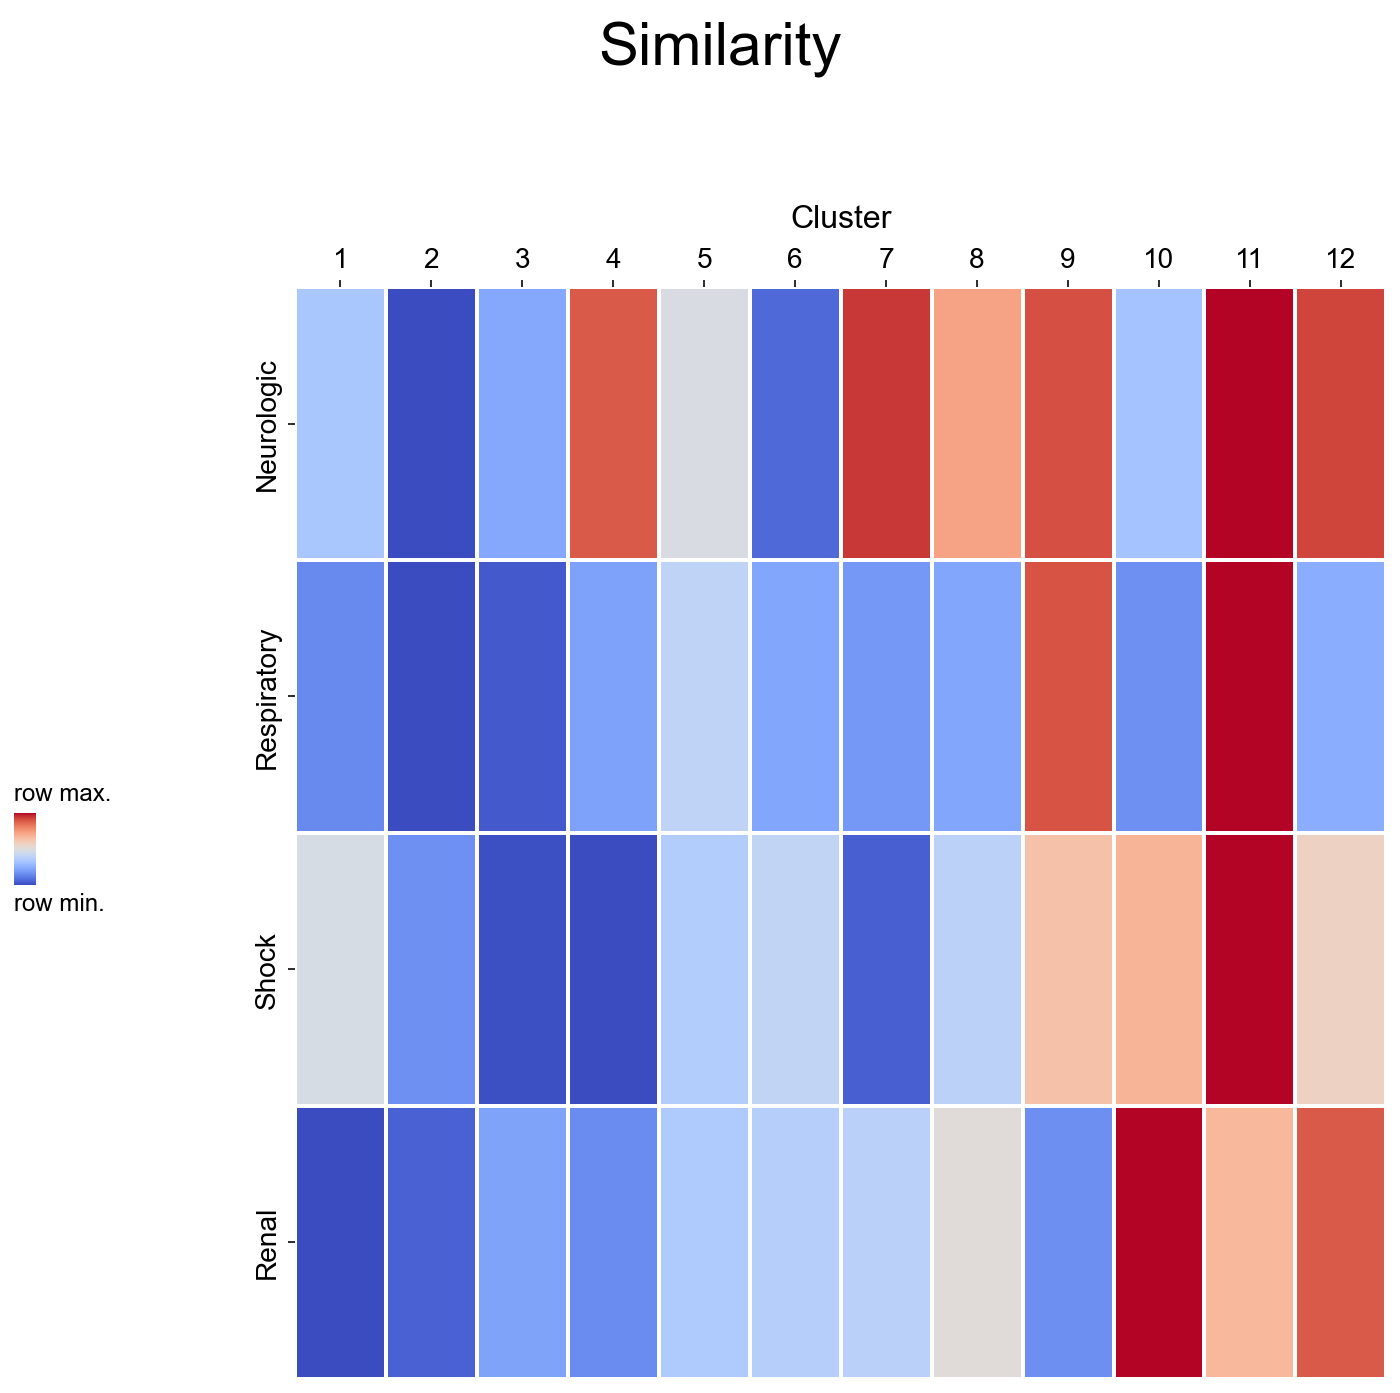

In [49]:
for key in approaches.keys():
    
    quilt4(
    data_with_mortality=data,
    data_mtx=approaches[key]['feature_matrix'],
    assignment=approaches[key]['assignments'][12]
        )

    plt.suptitle(f'{key}',fontsize=30, )
        
    dump_figure(
    f'quilt4_12-{key}.pdf')
    

In [50]:
dump_table(data, 'mimic_minus_NA.csv.gz')

/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/pynndescent/pynndescent_.py:891: UserWarning: Failed to correctly find n_neighbors for some samples.Results may be less than ideal. Try re-running withdifferent parameters.
  warn(
/Users/cag895/OneDrive - Northwestern University/CarpeDiem/VirEnvJuly22/lib/python3.8/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


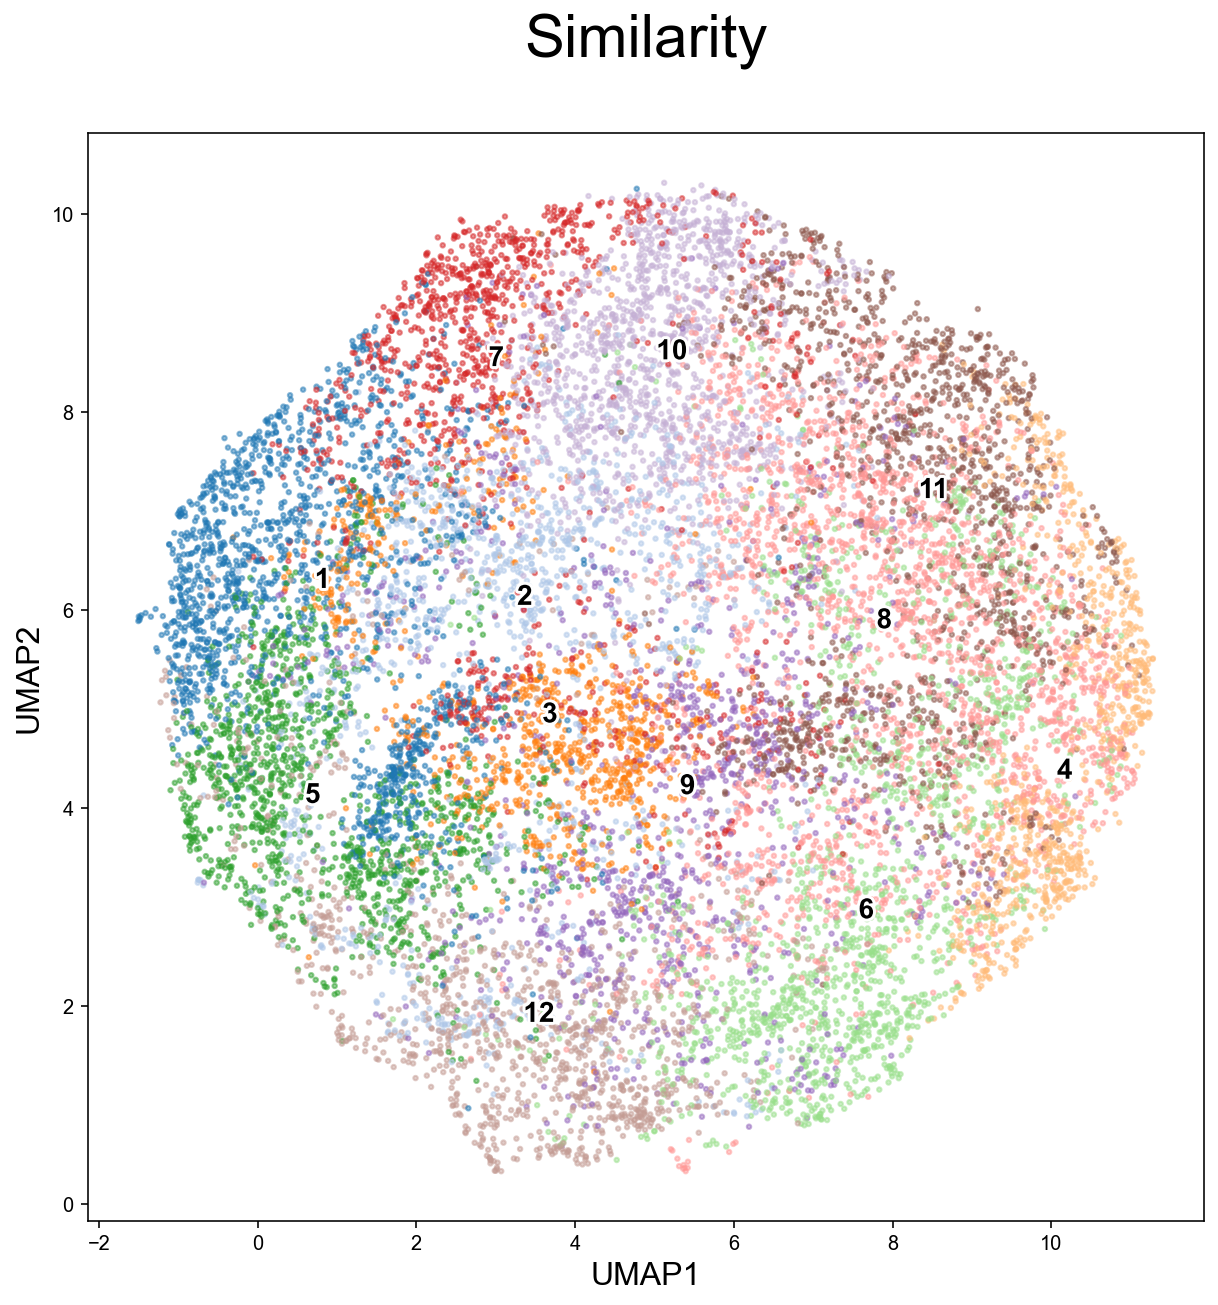

In [51]:
for key in approaches.keys():
    umap_data = clustering.show_umap(
    data=approaches[key]['data_dist'],
    assignment = approaches[key]['assignments'][12] )

    plt.title(f'{key}\n', fontsize=30, loc='center')
    
    # #save umaps
    # data["umap1"] = umap_data[:, 0]
    # data["umap2"] = umap_data[:, 1]
    # data = clustering.index_by_patient_ids_icu_stay_day(data)
    # dump_table(data, f'{key}-umap.csv.gz')
    
    dump_figure(
        f'umap-{key}.pdf')

In [53]:
data.shape

(15642, 43)

In [54]:
data.columns

Index(['index', 'Patient_id', 'intime', 'outtime', 'los', 'day', 'day',
       'Intubation_flag', 'Norepinephrine_rate', 'Mean_arterial_pressure',
       'min_gcs', 'Urine_output', 'Bilirubin', 'Creatinine', 'Platelets',
       'SOFA_score', 'Dialysis_flag', 'FiO2', 'PEEP', 'Vent_respiratory_rate',
       'Tidal_volume', 'avg_mv', 'Plateau_pressure', 'min_hr', 'Heart_rate',
       'min_rr', 'Respiratory_rate', 'min_temp', 'Temperature',
       'Oxygen_saturation', 'ABG_pH', 'ABG_PaCO2', 'ECMO_flag', 'RASS_score',
       'GCS_verbal_response', 'GCS_motor_response', 'GCS_eye_opening',
       'PaO2FIO2_ratio', 'discharge_location', 'Binary_outcome',
       'Norepinephrine_flag', 'umap1', 'umap2'],
      dtype='object')